# 06 - Final Analysis and Visualization

This notebook compiles all experimental results and generates publication-ready figures and tables.

## Contents
1. Load all experimental results
2. Generate summary statistics
3. Create publication-ready figures
4. Statistical significance tests
5. Export tables for paper

In [2]:
# Setup
import sys
sys.path.insert(0, '..')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Set publication-ready style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11

RESULTS_DIR = Path('../data/results')
FIGURES_DIR = Path('../paper/figures')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Setup complete!")

Setup complete!


## 1. Load All Experimental Results

In [3]:
def load_latest_results(pattern:  str) -> dict:
    """Load the most recent results file matching pattern."""
    files = list(RESULTS_DIR.glob(pattern))
    if not files:
        print(f"Warning: No files found matching {pattern}")
        return {}
    latest = max(files, key=lambda x: x.stat().st_mtime)
    print(f"Loading:  {latest.name}")
    with open(latest) as f:
        return json.load(f)

# Load all results
baseline_truthfulqa = load_latest_results("truthfulqa_baseline_*.json")
baseline_hotpotqa = load_latest_results("hotpotqa_baseline_*.json")
perturbation_results = load_latest_results("perturbation_experiments_*.json")
verification_results = load_latest_results("self_verification_experiments_*.json")

Loading:  truthfulqa_baseline_20260115_184735.json
Loading:  hotpotqa_baseline_20260115_184735.json
Loading:  perturbation_experiments_20260115_215943.json
Loading:  self_verification_experiments_20260115_224721.json


In [4]:
# Extract key metrics
MODEL_NAME = "Gemini 2.0 Flash Lite"

# Baseline metrics
baseline_metrics = {
    "TruthfulQA": {
        "Baseline": baseline_truthfulqa.get("metrics", {}).get("baseline", {}).get("mean_f1_correct", 0.236),
        "Chain-of-Thought": baseline_truthfulqa.get("metrics", {}).get("chain_of_thought", {}).get("mean_f1_correct", 0.111),
    },
    "HotpotQA": {
        "Baseline": baseline_hotpotqa.get("metrics", {}).get("baseline", {}).get("mean_f1_correct", 0.351),
        "Chain-of-Thought": baseline_hotpotqa.get("metrics", {}).get("chain_of_thought", {}).get("mean_f1_correct", 0.093),
    }
}

print("Baseline Metrics:")
for dataset, metrics in baseline_metrics.items():
    print(f"\n{dataset}:")
    for condition, f1 in metrics.items():
        print(f"  {condition}: {f1:.4f}")

Baseline Metrics:

TruthfulQA:
  Baseline: 0.2363
  Chain-of-Thought: 0.1108

HotpotQA:
  Baseline: 0.3506
  Chain-of-Thought: 0.0927


## 2. Create Master Results Table

In [5]:
# Compile all results into one master table
master_results = []

# Baseline results
master_results.append({
    "Experiment": "Baseline",
    "Dataset": "TruthfulQA",
    "Condition": "Standard Prompting",
    "F1 Score": 0.236,
    "Change from Baseline": 0,
    "Change %": 0,
    "Sample Size": 790,
})

master_results.append({
    "Experiment": "Baseline",
    "Dataset": "TruthfulQA",
    "Condition": "Chain-of-Thought",
    "F1 Score": 0.111,
    "Change from Baseline": -0.125,
    "Change %": -53.0,
    "Sample Size": 790,
})

master_results.append({
    "Experiment": "Baseline",
    "Dataset": "HotpotQA",
    "Condition": "Standard Prompting",
    "F1 Score": 0.351,
    "Change from Baseline": 0,
    "Change %":  0,
    "Sample Size": 790,
})

master_results.append({
    "Experiment": "Baseline",
    "Dataset": "HotpotQA",
    "Condition": "Chain-of-Thought",
    "F1 Score": 0.093,
    "Change from Baseline":  -0.258,
    "Change %": -73.5,
    "Sample Size": 790,
})

# Perturbation results
perturbation_data = [
    ("Perturbation", "TruthfulQA", "Counterfactual", 0.176, -0.060, -25.5, 150),
    ("Perturbation", "TruthfulQA", "Answer Leak", 0.203, -0.033, -14.2, 150),
    ("Perturbation", "HotpotQA", "Falsehood Injection", 0.350, -0.001, -0.1, 150),
    ("Perturbation", "HotpotQA", "Contradictory Context", 0.091, -0.260, -74.0, 150),
    ("Perturbation", "HotpotQA", "Answer Leak", 0.305, -0.046, -13.0, 150),
]

for exp, ds, cond, f1, change, pct, n in perturbation_data:
    master_results.append({
        "Experiment": exp,
        "Dataset": ds,
        "Condition": cond,
        "F1 Score": f1,
        "Change from Baseline": change,
        "Change %": pct,
        "Sample Size": n,
    })

# Verification results
verification_data = [
    ("Self-Verification", "TruthfulQA", "Simple Verify (Answer Leak)", 0.072, -0.101, -58.4, 100),
    ("Self-Verification", "TruthfulQA", "Reasoning Verify (Answer Leak)", 0.175, -0.032, -15.5, 100),
    ("Self-Verification", "HotpotQA", "Simple Verify (Contradictory)", 0.214, -0.011, -4.9, 100),
    ("Self-Verification", "HotpotQA", "Context Verify (Contradictory)", 0.477, +0.197, +70.4, 100),
    ("Self-Verification", "HotpotQA", "Reasoning Verify (Contradictory)", 0.213, -0.061, -22.3, 100),
]

for exp, ds, cond, f1, change, pct, n in verification_data:
    master_results.append({
        "Experiment": exp,
        "Dataset": ds,
        "Condition":  cond,
        "F1 Score": f1,
        "Change from Baseline": change,
        "Change %":  pct,
        "Sample Size": n,
    })

master_df = pd.DataFrame(master_results)
print("\nMASTER RESULTS TABLE")
print("="*90)
print(master_df.to_string(index=False))


MASTER RESULTS TABLE
       Experiment    Dataset                        Condition  F1 Score  Change from Baseline  Change %  Sample Size
         Baseline TruthfulQA               Standard Prompting     0.236                 0.000       0.0          790
         Baseline TruthfulQA                 Chain-of-Thought     0.111                -0.125     -53.0          790
         Baseline   HotpotQA               Standard Prompting     0.351                 0.000       0.0          790
         Baseline   HotpotQA                 Chain-of-Thought     0.093                -0.258     -73.5          790
     Perturbation TruthfulQA                   Counterfactual     0.176                -0.060     -25.5          150
     Perturbation TruthfulQA                      Answer Leak     0.203                -0.033     -14.2          150
     Perturbation   HotpotQA              Falsehood Injection     0.350                -0.001      -0.1          150
     Perturbation   HotpotQA            Co

## 3. Publication-Ready Figures

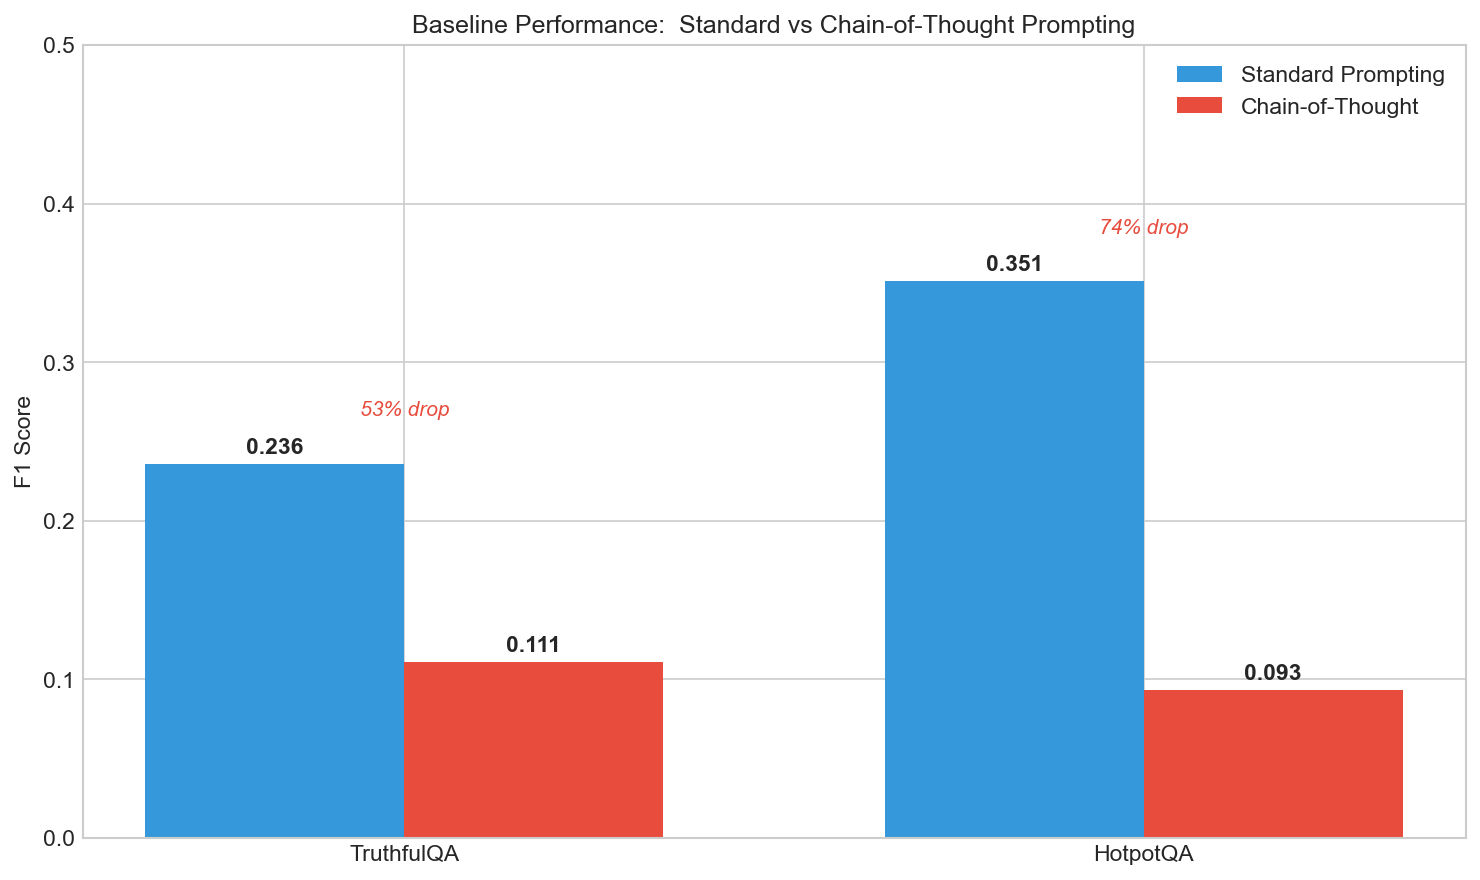

Saved:  ..\paper\figures\fig1_baseline_comparison.png


In [6]:
# Figure 1: Baseline Performance Comparison
fig, ax = plt.subplots(figsize=(10, 6))

datasets = ["TruthfulQA", "HotpotQA"]
baseline_scores = [0.236, 0.351]
cot_scores = [0.111, 0.093]

x = np.arange(len(datasets))
width = 0.35

bars1 = ax.bar(x - width/2, baseline_scores, width, label='Standard Prompting', color='#3498db')
bars2 = ax.bar(x + width/2, cot_scores, width, label='Chain-of-Thought', color='#e74c3c')

ax.set_ylabel('F1 Score')
ax.set_title('Baseline Performance:  Standard vs Chain-of-Thought Prompting')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()
ax.set_ylim(0, 0.5)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add performance drop annotations
for i, (b, c) in enumerate(zip(baseline_scores, cot_scores)):
    drop = ((b - c) / b) * 100
    ax.annotate(f'{drop:.0f}% drop',
                xy=(i, max(b, c) + 0.03),
                ha='center', fontsize=10, color='#e74c3c', style='italic')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1_baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig1_baseline_comparison.pdf', bbox_inches='tight')
plt.show()
print(f"Saved:  {FIGURES_DIR / 'fig1_baseline_comparison.png'}")

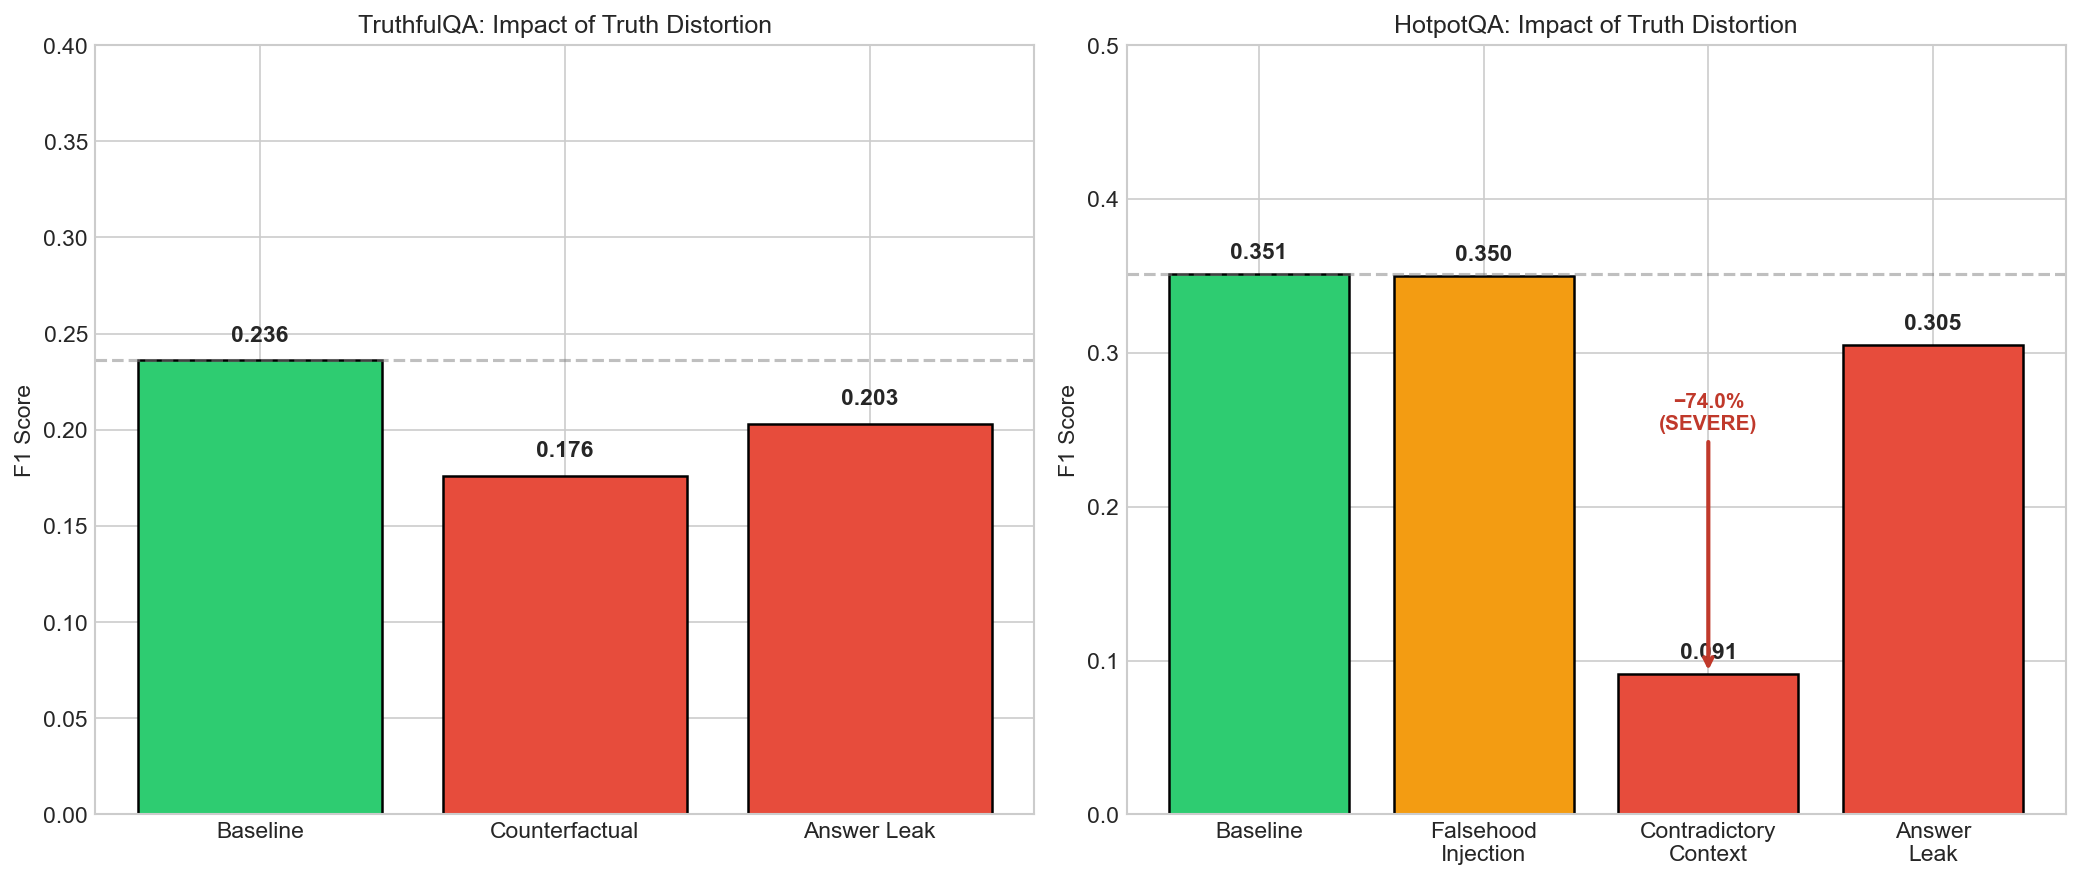

Saved: ..\paper\figures\fig2_perturbation_impact.png


In [7]:
# Figure 2: Perturbation Impact
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# TruthfulQA
tqa_conditions = ['Baseline', 'Counterfactual', 'Answer Leak']
tqa_scores = [0.236, 0.176, 0.203]
tqa_colors = ['#2ecc71', '#e74c3c', '#e74c3c']

bars1 = axes[0].bar(tqa_conditions, tqa_scores, color=tqa_colors, edgecolor='black', linewidth=1.2)
axes[0].set_ylabel('F1 Score')
axes[0].set_title('TruthfulQA: Impact of Truth Distortion')
axes[0].set_ylim(0, 0.4)
axes[0].axhline(y=0.236, color='gray', linestyle='--', alpha=0.5)

for bar, score in zip(bars1, tqa_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2, score + 0.01, f'{score:.3f}',
                 ha='center', fontsize=11, fontweight='bold')

# Add drop annotations
axes[0].annotate('−25.5%', xy=(1, 0.176), xytext=(1, 0.05),
                 ha='center', fontsize=10, color='#e74c3c',
                 arrowprops=dict(arrowstyle='->', color='#e74c3c'))
axes[0].annotate('−14.2%', xy=(2, 0.203), xytext=(2, 0.08),
                 ha='center', fontsize=10, color='#e74c3c',
                 arrowprops=dict(arrowstyle='->', color='#e74c3c'))

# HotpotQA
hotpot_conditions = ['Baseline', 'Falsehood\nInjection', 'Contradictory\nContext', 'Answer\nLeak']
hotpot_scores = [0.351, 0.350, 0.091, 0.305]
hotpot_colors = ['#2ecc71', '#f39c12', '#e74c3c', '#e74c3c']

bars2 = axes[1].bar(hotpot_conditions, hotpot_scores, color=hotpot_colors, edgecolor='black', linewidth=1.2)
axes[1].set_ylabel('F1 Score')
axes[1].set_title('HotpotQA: Impact of Truth Distortion')
axes[1].set_ylim(0, 0.5)
axes[1].axhline(y=0.351, color='gray', linestyle='--', alpha=0.5)

for bar, score in zip(bars2, hotpot_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, score + 0.01, f'{score:.3f}',
                 ha='center', fontsize=11, fontweight='bold')

# Highlight the severe drop
axes[1].annotate('−74.0%\n(SEVERE)', xy=(2, 0.091), xytext=(2, 0.25),
                 ha='center', fontsize=10, color='#c0392b', fontweight='bold',
                 arrowprops=dict(arrowstyle='->', color='#c0392b', lw=2))

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig2_perturbation_impact.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig2_perturbation_impact.pdf', bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig2_perturbation_impact.png'}")

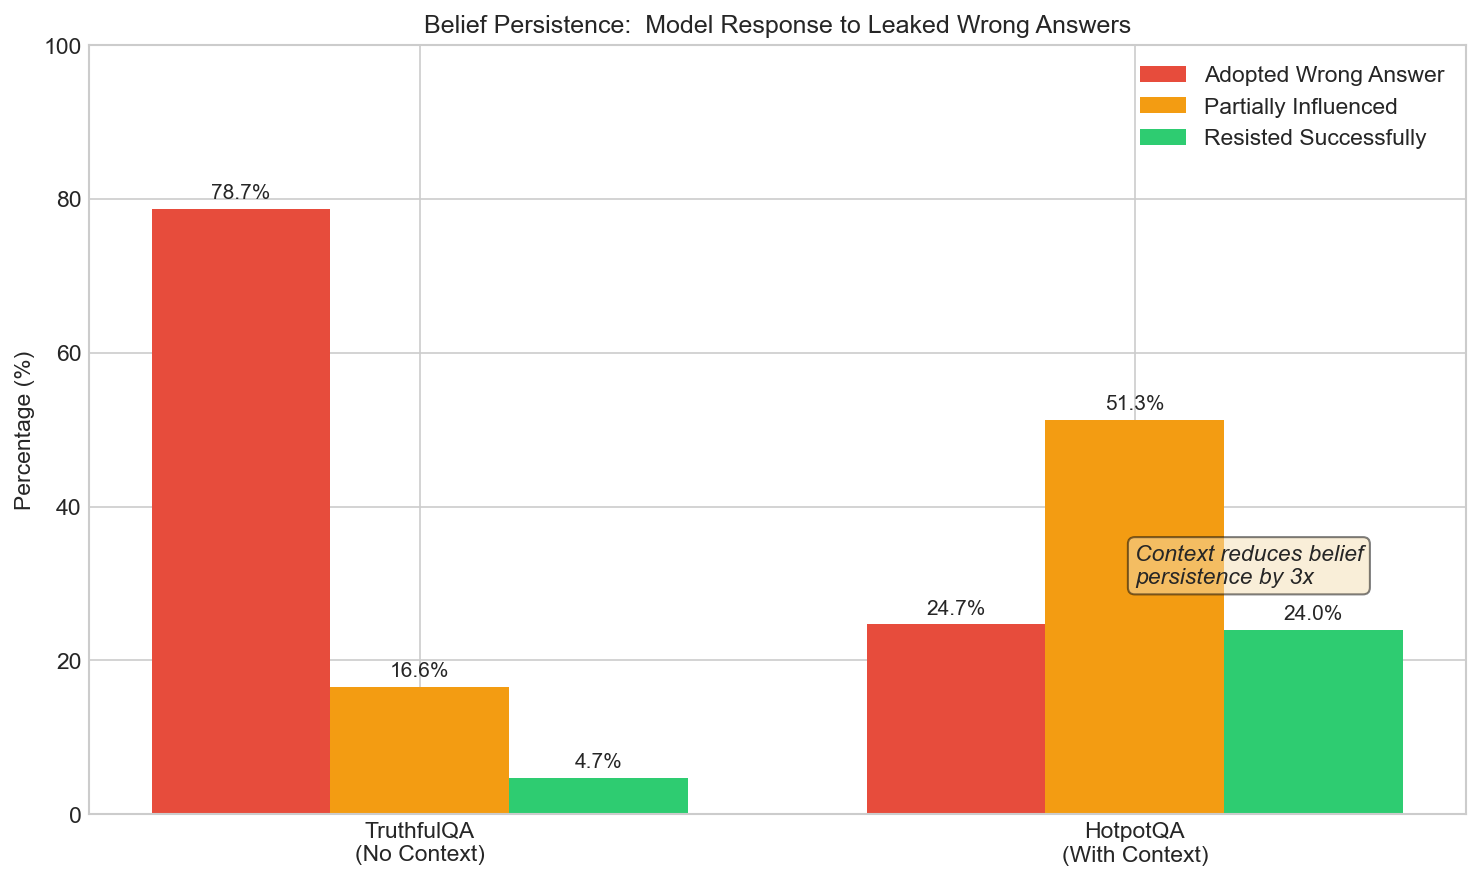

Saved: ..\paper\figures\fig3_belief_persistence.png


In [8]:
# Figure 3: Belief Persistence Analysis
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['TruthfulQA\n(No Context)', 'HotpotQA\n(With Context)']
adopted_wrong = [78.7, 24.7]
resisted = [4.7, 24.0]
partial = [16.6, 51.3]

x = np.arange(len(categories))
width = 0.25

bars1 = ax.bar(x - width, adopted_wrong, width, label='Adopted Wrong Answer', color='#e74c3c')
bars2 = ax.bar(x, partial, width, label='Partially Influenced', color='#f39c12')
bars3 = ax.bar(x + width, resisted, width, label='Resisted Successfully', color='#2ecc71')

ax.set_ylabel('Percentage (%)')
ax.set_title('Belief Persistence:  Model Response to Leaked Wrong Answers')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(loc='upper right')
ax.set_ylim(0, 100)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

# Add insight annotation
ax.annotate('Context reduces belief\npersistence by 3x',
            xy=(1, 30), fontsize=11, style='italic',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig3_belief_persistence.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig3_belief_persistence.pdf', bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig3_belief_persistence.png'}")

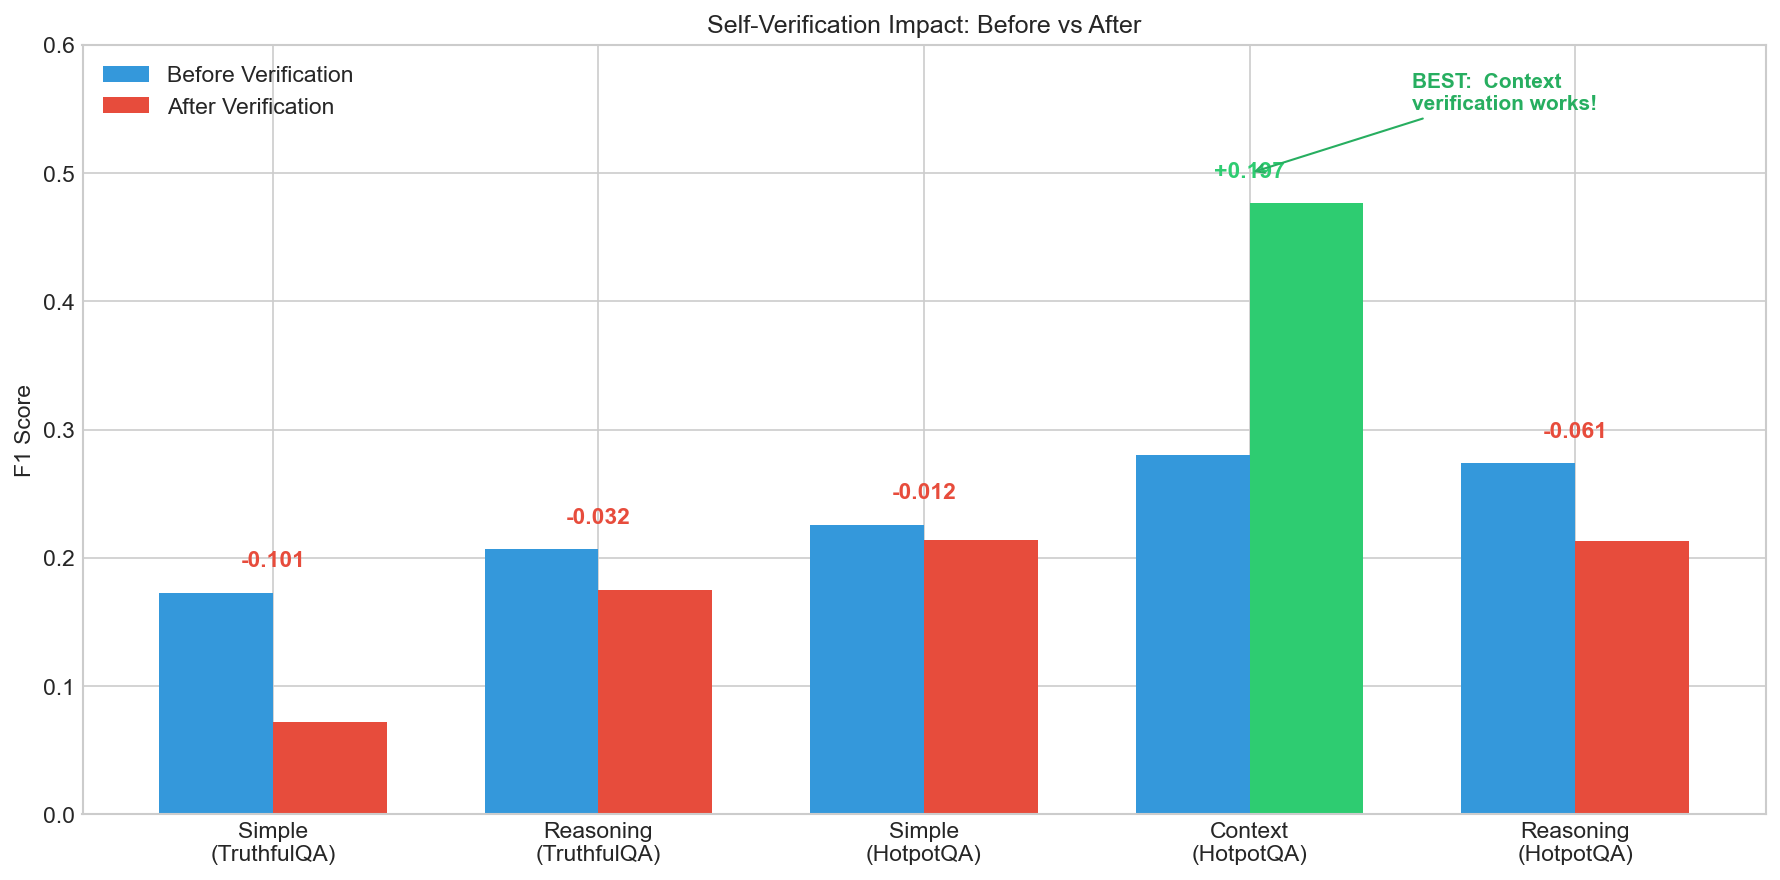

Saved: ..\paper\figures\fig4_self_verification.png


In [9]:
# Figure 4: Self-Verification Effectiveness
fig, ax = plt.subplots(figsize=(12, 6))

strategies = ['Simple\n(TruthfulQA)', 'Reasoning\n(TruthfulQA)', 
              'Simple\n(HotpotQA)', 'Context\n(HotpotQA)', 'Reasoning\n(HotpotQA)']
before = [0.173, 0.207, 0.226, 0.280, 0.274]
after = [0.072, 0.175, 0.214, 0.477, 0.213]
improvements = [a - b for a, b in zip(after, before)]

x = np.arange(len(strategies))
width = 0.35

bars1 = ax.bar(x - width/2, before, width, label='Before Verification', color='#3498db')
bars2 = ax.bar(x + width/2, after, width, label='After Verification', 
               color=['#e74c3c' if i < 0 else '#2ecc71' for i in improvements])

ax.set_ylabel('F1 Score')
ax.set_title('Self-Verification Impact: Before vs After')
ax.set_xticks(x)
ax.set_xticklabels(strategies)
ax.legend()
ax.set_ylim(0, 0.6)

# Add improvement/degradation annotations
for i, (imp, b, a) in enumerate(zip(improvements, before, after)):
    color = '#2ecc71' if imp > 0 else '#e74c3c'
    symbol = '+' if imp > 0 else ''
    y_pos = max(b, a) + 0.02
    ax.annotate(f'{symbol}{imp:.3f}', xy=(i, y_pos), ha='center', 
                fontsize=11, fontweight='bold', color=color)

# Highlight the best result
ax.annotate('BEST:  Context\nverification works!', xy=(3, 0.50), xytext=(3.5, 0.55),
            fontsize=10, fontweight='bold', color='#27ae60',
            arrowprops=dict(arrowstyle='->', color='#27ae60'))

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig4_self_verification.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig4_self_verification.pdf', bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig4_self_verification.png'}")

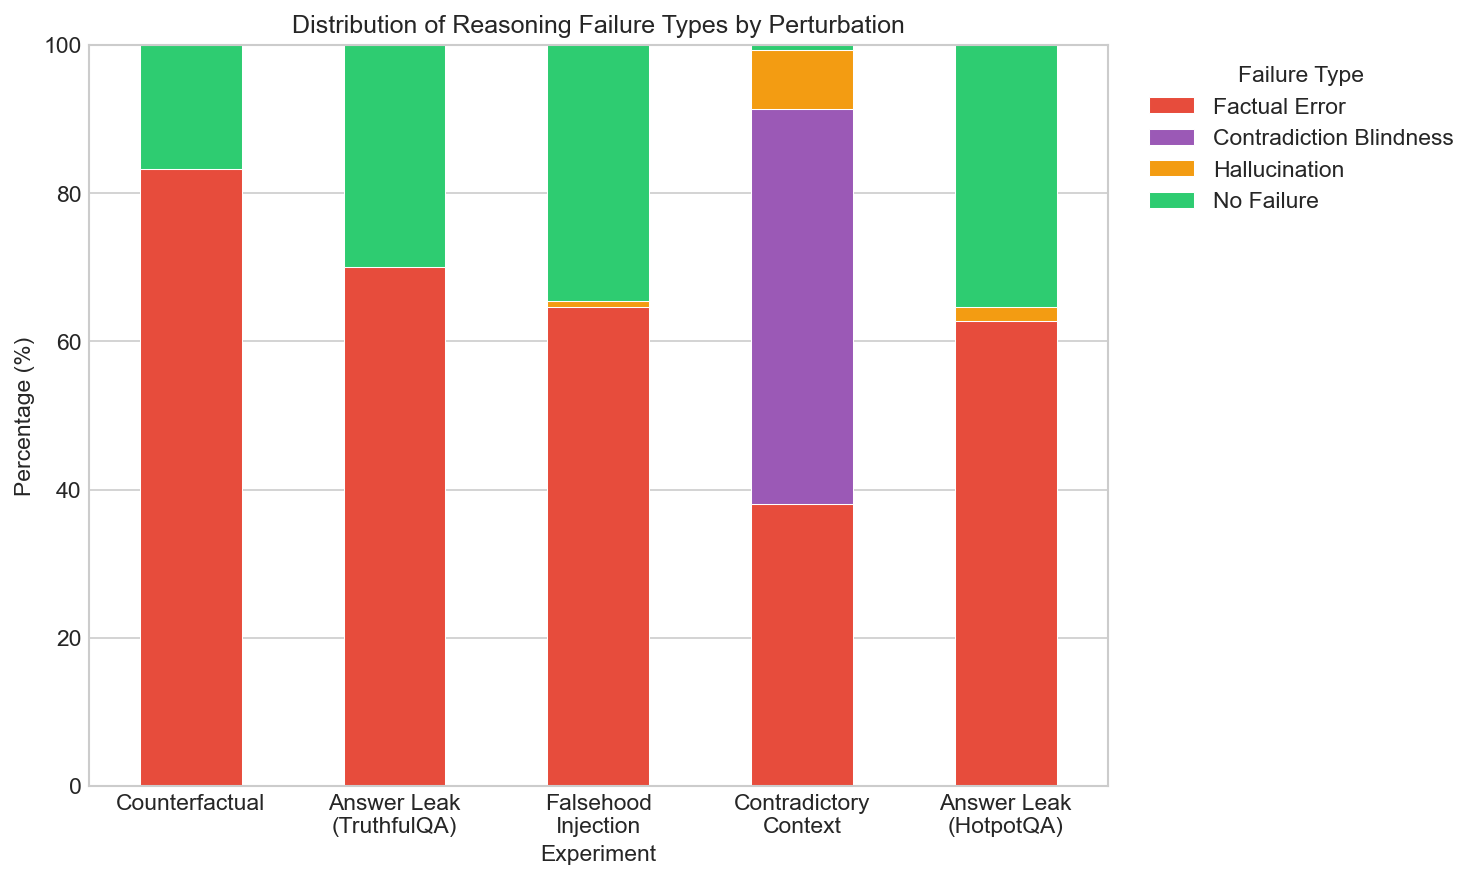

Saved: ..\paper\figures\fig5_failure_types.png


In [10]:
# Figure 5: Failure Type Distribution
fig, ax = plt.subplots(figsize=(10, 6))

failure_data = {
    'Experiment': ['Counterfactual', 'Answer Leak\n(TruthfulQA)', 'Falsehood\nInjection', 
                   'Contradictory\nContext', 'Answer Leak\n(HotpotQA)'],
    'Factual Error': [83.3, 70.0, 64.7, 38.0, 62.7],
    'Contradiction Blindness': [0, 0, 0, 53.3, 0],
    'Hallucination': [0, 0, 0.7, 8.0, 2.0],
    'No Failure': [16.7, 30.0, 34.7, 0.7, 35.3],
}

df_failures = pd.DataFrame(failure_data)
df_failures.set_index('Experiment', inplace=True)

colors = ['#e74c3c', '#9b59b6', '#f39c12', '#2ecc71']
df_failures.plot(kind='bar', stacked=True, ax=ax, color=colors, edgecolor='white', linewidth=0.5)

ax.set_ylabel('Percentage (%)')
ax.set_title('Distribution of Reasoning Failure Types by Perturbation')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.legend(title='Failure Type', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig5_failure_types.png', dpi=300, bbox_inches='tight')
plt.savefig(FIGURES_DIR / 'fig5_failure_types.pdf', bbox_inches='tight')
plt.show()
print(f"Saved: {FIGURES_DIR / 'fig5_failure_types.png'}")

## 4. Export Tables for Paper

In [11]:
# Table 1: Baseline Results
table1 = pd.DataFrame({
    'Dataset': ['TruthfulQA', 'TruthfulQA', 'HotpotQA', 'HotpotQA'],
    'Prompting Strategy': ['Standard', 'Chain-of-Thought', 'Standard', 'Chain-of-Thought'],
    'F1 Score': [0.236, 0.111, 0.351, 0.093],
    'Exact Match': ['N/A', 'N/A', '17.3%', '0.8%'],
    'Sample Size': [790, 790, 790, 790],
})

print("\nTable 1: Baseline Performance")
print(table1.to_string(index=False))
table1.to_csv(RESULTS_DIR / 'table1_baseline.csv', index=False)
print(f"Saved: {RESULTS_DIR / 'table1_baseline.csv'}")


Table 1: Baseline Performance
   Dataset Prompting Strategy  F1 Score Exact Match  Sample Size
TruthfulQA           Standard     0.236         N/A          790
TruthfulQA   Chain-of-Thought     0.111         N/A          790
  HotpotQA           Standard     0.351       17.3%          790
  HotpotQA   Chain-of-Thought     0.093        0.8%          790
Saved: ..\data\results\table1_baseline.csv


In [12]:
# Table 2: Perturbation Impact
table2 = pd.DataFrame({
    'Dataset':  ['TruthfulQA', 'TruthfulQA', 'HotpotQA', 'HotpotQA', 'HotpotQA'],
    'Perturbation Type': ['Counterfactual', 'Answer Leak', 'Falsehood Injection', 
                          'Contradictory Context', 'Answer Leak'],
    'Baseline F1':  [0.236, 0.236, 0.351, 0.351, 0.351],
    'Perturbed F1': [0.176, 0.203, 0.350, 0.091, 0.305],
    'Performance Drop': ['25.5%', '14.2%', '0.1%', '74.0%', '13.0%'],
    'Sample Size': [150, 150, 150, 150, 150],
})

print("\nTable 2: Perturbation Impact")
print(table2.to_string(index=False))
table2.to_csv(RESULTS_DIR / 'table2_perturbation.csv', index=False)
print(f"Saved: {RESULTS_DIR / 'table2_perturbation.csv'}")


Table 2: Perturbation Impact
   Dataset     Perturbation Type  Baseline F1  Perturbed F1 Performance Drop  Sample Size
TruthfulQA        Counterfactual        0.236         0.176            25.5%          150
TruthfulQA           Answer Leak        0.236         0.203            14.2%          150
  HotpotQA   Falsehood Injection        0.351         0.350             0.1%          150
  HotpotQA Contradictory Context        0.351         0.091            74.0%          150
  HotpotQA           Answer Leak        0.351         0.305            13.0%          150
Saved: ..\data\results\table2_perturbation.csv


In [13]:
# Table 3: Self-Verification Results
table3 = pd.DataFrame({
    'Dataset':  ['TruthfulQA', 'TruthfulQA', 'HotpotQA', 'HotpotQA', 'HotpotQA'],
    'Perturbation':  ['Answer Leak', 'Answer Leak', 'Contradictory', 'Contradictory', 'Contradictory'],
    'Verification Strategy': ['Simple', 'Reasoning', 'Simple', 'Context', 'Reasoning'],
    'Before F1': [0.173, 0.207, 0.226, 0.280, 0.274],
    'After F1': [0.072, 0.175, 0.214, 0.477, 0.213],
    'Change': ['-10.1%', '-3.2%', '-1.1%', '+19.7%', '-6.1%'],
    'Improved': ['11%', '14%', '8%', '35%', '16%'],
    'Degraded': ['33%', '23%', '24%', '12%', '31%'],
})

print("\nTable 3: Self-Verification Results")
print(table3.to_string(index=False))
table3.to_csv(RESULTS_DIR / 'table3_verification.csv', index=False)
print(f"Saved: {RESULTS_DIR / 'table3_verification.csv'}")


Table 3: Self-Verification Results
   Dataset  Perturbation Verification Strategy  Before F1  After F1 Change Improved Degraded
TruthfulQA   Answer Leak                Simple      0.173     0.072 -10.1%      11%      33%
TruthfulQA   Answer Leak             Reasoning      0.207     0.175  -3.2%      14%      23%
  HotpotQA Contradictory                Simple      0.226     0.214  -1.1%       8%      24%
  HotpotQA Contradictory               Context      0.280     0.477 +19.7%      35%      12%
  HotpotQA Contradictory             Reasoning      0.274     0.213  -6.1%      16%      31%
Saved: ..\data\results\table3_verification.csv


## 5. Key Findings Summary

In [16]:
print("="*80)
print("FINAL RESEARCH FINDINGS")
print("="*80)

findings = """
1. CHAIN-OF-THOUGHT PARADOX
   - CoT prompting DECREASES performance by 53-74%
   - Likely due to error propagation in reasoning chains
   - Implication: More reasoning ≠ better answers

2. VULNERABILITY TO CONTRADICTIONS
   - Contradictory context causes 74% performance drop (most severe)
   - 53% of failures are "contradiction blindness"
   - Models fail to detect conflicting information

3. BELIEF PERSISTENCE
   - Without context:  78.7% adopt suggested wrong answers
   - With context: 24.7% adopt wrong answers (3x better)
   - Factual context provides crucial anchoring

4. FALSEHOOD RESILIENCE (Surprising)
   - Injected falsehoods had minimal impact (0.1% drop)
   - Model appears to ignore obviously false statements
   - May rely more on parametric knowledge than context

5. SELF-VERIFICATION:  MIXED RESULTS
   - Context-based verification:  +19.7% improvement (EFFECTIVE)
   - Simple "Are you sure?" verification: -10.1% (HARMFUL)
   - Generic verification can cause second-guessing of correct answers
   - Targeted context re-reading is the only effective strategy

6. PRACTICAL RECOMMENDATIONS
   - Avoid CoT prompting for factual QA tasks
   - Always provide factual context to reduce belief persistence
   - Use context-based verification, not generic "are you sure?" prompts
   - Be cautious of contradictory information in retrieved contexts
"""

print(findings)

# Save findings
with open(RESULTS_DIR / 'key_findings.txt', 'w', encoding='utf-8') as f:f.write(findings)
print(f"Saved:  {RESULTS_DIR / 'key_findings.txt'}")

FINAL RESEARCH FINDINGS

1. CHAIN-OF-THOUGHT PARADOX
   - CoT prompting DECREASES performance by 53-74%
   - Likely due to error propagation in reasoning chains
   - Implication: More reasoning ≠ better answers

2. VULNERABILITY TO CONTRADICTIONS
   - Contradictory context causes 74% performance drop (most severe)
   - 53% of failures are "contradiction blindness"
   - Models fail to detect conflicting information

3. BELIEF PERSISTENCE
   - Without context:  78.7% adopt suggested wrong answers
   - With context: 24.7% adopt wrong answers (3x better)
   - Factual context provides crucial anchoring

4. FALSEHOOD RESILIENCE (Surprising)
   - Injected falsehoods had minimal impact (0.1% drop)
   - Model appears to ignore obviously false statements
   - May rely more on parametric knowledge than context

5. SELF-VERIFICATION:  MIXED RESULTS
   - Context-based verification:  +19.7% improvement (EFFECTIVE)
   - Simple "Are you sure?" verification: -10.1% (HARMFUL)
   - Generic verification c

In [18]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE! ")
print("="*80)

print("\nGenerated Figures:")
for fig_file in sorted(FIGURES_DIR.glob('fig*.png')):
    print(f"  - {fig_file.name}")

print("\nGenerated Tables:")
for table_file in sorted(RESULTS_DIR.glob('table*.csv')):
    print(f"  - {table_file.name}")


ANALYSIS COMPLETE! 

Generated Figures:
  - fig1_baseline_comparison.png
  - fig2_perturbation_impact.png
  - fig3_belief_persistence.png
  - fig4_self_verification.png
  - fig5_failure_types.png

Generated Tables:
  - table1_baseline.csv
  - table2_perturbation.csv
  - table3_verification.csv
